# Pre-requisites

In [22]:
# sets *your* project id
PROJECT_ID = "esicmdatathon2024" #@param {type:"string"}


In [23]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [24]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')


Authenticated


In [25]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [26]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config


# Import libraries

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# get all Creatinine outside of visit date range
Look for Creatinine (3020564). Get all measurements before admission or after discharge.

In [45]:
%%bigquery df --project esicmdatathon2024
with cr_all as (
  SELECT m.measurement_id, m.person_id, m.visit_occurrence_id
  , m.measurement_datetime
  , value_as_number as creatinine
  FROM measurement m
  WHERE
    NOT provider_id IS NULL -- ignore unvalidated device data
    and measurement_concept_id = 3020564 -- Creatinine [Moles/volume] in Serum or Plasma
)
, admission as (
  select person_id, visit_occurrence_id
  , visit_start_datetime, visit_end_datetime
  from visit_occurrence v
)
select a.visit_occurrence_id
, case when measurement_datetime < visit_start_datetime
        then timestamp_diff(b.measurement_datetime, a.visit_start_datetime, MINUTE  )/60.0  end as admit_till_measure
, case when measurement_datetime > visit_end_datetime
        then timestamp_diff( b.measurement_datetime, a.visit_end_datetime, MINUTE  )/60.0 end as measure_till_discharge
, b.creatinine, b.measurement_id
from admission a -- to get the admission date for reference
inner join cr_all b
on a.visit_occurrence_id = b.visit_occurrence_id
where b.measurement_datetime < a.visit_start_datetime
or b.measurement_datetime > a.visit_end_datetime

Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
# s = df.select_dtypes(include='object').columns
# df[s] = df[s].astype("float")


In [44]:
df.describe()

,visit_occurrence_id,admit_till_measure,measure_till_discharge,measurement_id
count,49957.0,49537.000000,420.000000,49957.0
mean,11609.603799,-147.937262,517.755992,773356784.641612
std,6779.292628,389.265309,620.191950,398238542.527346
min,0.0,-13490.283333,0.050000,64518220.0
25%,5814.0,-177.316667,19.325000,425903580.0
50%,11591.0,-71.216667,212.641667,801840549.0
75%,17513.0,-22.750000,914.816667,1115929730.0
max,23552.0,-0.016667,2154.516667,1437646286.0


In [48]:
df.shape

(49957, 5)

# Plot hours of difference
Measurements before the admission show up negative hours on X axis. Measurements after discharge show up positive hours on the X axis.

(array([5.0000e+00, 2.0000e+00, 9.0000e+00, 1.0000e+00, 5.0000e+00,
        1.3000e+01, 5.4000e+01, 1.3100e+02, 4.1800e+02, 4.8899e+04]),
 array([-1.34902833e+04, -1.21412567e+04, -1.07922300e+04, -9.44320333e+03,
        -8.09417667e+03, -6.74515000e+03, -5.39612333e+03, -4.04709667e+03,
        -2.69807000e+03, -1.34904333e+03, -1.66666667e-02]),
 <BarContainer object of 10 artists>)

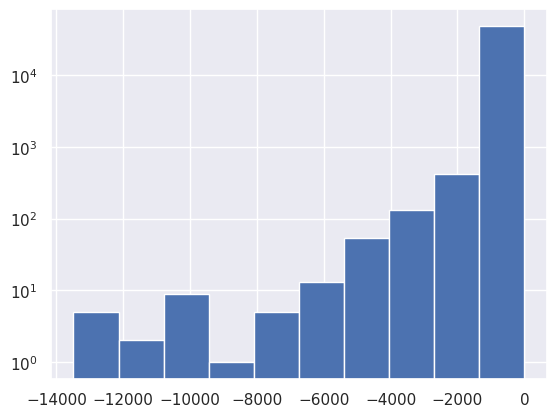

In [31]:
plt.hist(df['admit_till_measure'], log=True)

(array([212.,  42.,  34.,  22.,  22.,  29.,  13.,  14.,  13.,  19.]),
 array([5.00000000e-02, 2.15496667e+02, 4.30943333e+02, 6.46390000e+02,
        8.61836667e+02, 1.07728333e+03, 1.29273000e+03, 1.50817667e+03,
        1.72362333e+03, 1.93907000e+03, 2.15451667e+03]),
 <BarContainer object of 10 artists>)

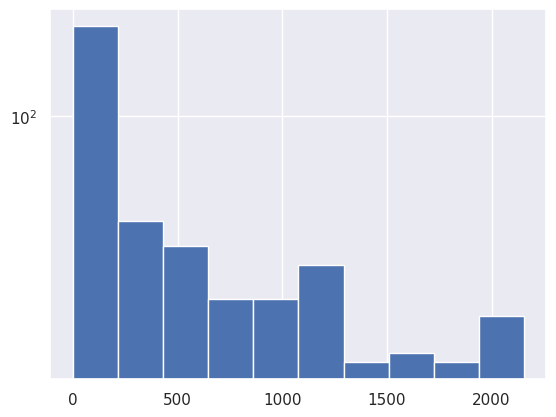

In [32]:
plt.hist(df['measure_till_discharge'], log=True)

In [33]:
df['visit_occurrence_id']

0          654
1          419
2         2266
3         1131
4          879
         ...  
49952    20643
49953    15993
49954     7233
49955    15104
49956    15104
Name: visit_occurrence_id, Length: 49957, dtype: Int64

# Check random example

In [52]:
df['visit_occurrence_id'].nunique()

20205

In [35]:
df.query('visit_occurrence_id == 15993')

<ipython-input-35-66aa2d60e0ea>:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query('visit_occurrence_id == 15993')


,visit_occurrence_id,admit_till_measure,measure_till_discharge,creatinine,measurement_id
49953,15993,-29.933333,NaN,87.00000000000000000000000000000000000000,1045492285


In [36]:
%%bigquery check_one_visit --project esicmdatathon2024
select m.person_id, m.visit_occurrence_id, m.measurement_datetime, m.value_as_number, m.*
FROM measurement m
  WHERE
    NOT provider_id IS NULL -- ignore unvalidated device data
    and measurement_concept_id = 3020564 -- Creatinine [Moles/volume] in Serum or Plasma
    and m.visit_occurrence_id = 15993
  limit 100

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
check_one_visit.head()

,person_id,visit_occurrence_id,measurement_datetime,value_as_number,measurement_id,person_id_1,measurement_concept_id,measurement_date,measurement_datetime_1,measurement_time,...,provider_id,visit_occurrence_id_1,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,13799,15993,2013-01-01 00:44:00+00:00,72.00000000000000000000000000000000000000,1045495623,13799,3020564,2013-01-01,2013-01-01 00:44:00+00:00,00:44:00,...,58,15993,<NA>,Kreatinine (bloed),<NA>,µmol/l,8749,72,<NA>,<NA>
1,13799,15993,2013-01-05 13:37:00+00:00,76.00000000000000000000000000000000000000,1045734593,13799,3020564,2013-01-05,2013-01-05 13:37:00+00:00,13:37:00,...,58,15993,<NA>,Kreatinine (bloed),<NA>,µmol/l,8749,76,<NA>,<NA>
2,13799,15993,2013-01-03 13:37:00+00:00,79.00000000000000000000000000000000000000,1045650127,13799,3020564,2013-01-03,2013-01-03 13:37:00+00:00,13:37:00,...,58,15993,<NA>,Kreatinine (bloed),<NA>,µmol/l,8749,79,<NA>,<NA>
3,13799,15993,2013-01-01 02:06:00+00:00,80.00000000000000000000000000000000000000,1045501065,13799,3020564,2013-01-01,2013-01-01 02:06:00+00:00,02:06:00,...,58,15993,<NA>,Kreatinine (bloed),<NA>,µmol/l,8749,80,<NA>,<NA>
4,13799,15993,2013-01-04 13:37:00+00:00,89.00000000000000000000000000000000000000,1045691916,13799,3020564,2013-01-04,2013-01-04 13:37:00+00:00,13:37:00,...,58,15993,<NA>,Kreatinine (bloed),<NA>,µmol/l,8749,89,<NA>,<NA>


In [38]:
%%bigquery check_one_person --project $PROJECT_ID
select v.*
 from visit_occurrence v
 inner join person o
 on v.person_id = o.person_id
 left join concept c
 on o.gender_concept_id = c.concept_id
where o.person_id = 13799


Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
check_one_person

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,provider_id,care_site_id,visit_source_value,visit_source_concept_id,admitted_from_concept_id,admitted_from_source_value,discharged_to_concept_id,discharged_to_source_value,preceding_visit_occurrence_id
0,15993,13799,32037,2013-01-01,2013-01-01 00:00:00+00:00,2013-01-05,2013-01-05 19:42:00+00:00,32827,1,1,IC,<NA>,8717,Verpleegafdeling zelfde ziekenhuis,9201,19,<NA>


# How many Creatinine measurements
There were 202700 creatinine measurements altogether. 49957 were outside of the visit date range, from 20205 visits.  

In [49]:
%%bigquery count_creatinine --project esicmdatathon2024
SELECT count(*) as count_all
  FROM measurement m
 WHERE
    NOT provider_id IS NULL -- ignore unvalidated device data
    and measurement_concept_id = 3020564 -- Creatinine [Moles/volume] in Serum or Plasma


Query is running:   0%|          |

Downloading:   0%|          |

In [51]:
count_creatinine

,count_all
0,202700


# Cleaning up

In [42]:
# clean up, optional
del df